In [1]:
from spaces import *
import numpy as np

In [2]:
statespace = Space()
statespace.append_dimension("x", np.ndarray((2,1)), init=np.array)
statespace.append_dimension("y", np.ndarray((1,1)), init=np.array)

In [3]:
innerspace = Space()
innerspace.append_dimension("u", np.ndarray((2,1)), init=np.array)

In [4]:
paramspace = Space()
paramspace.append_dimension("A", np.ndarray((2,2)), init=np.array)
paramspace.append_dimension("B", np.ndarray((2,2)), init=np.array)
paramspace.append_dimension("C", np.ndarray((2,1)), init=np.array)

In [5]:
### Replace this control_func with one that is a function of the params (and in doings so make the system stable)
control_func = lambda state: Point(innerspace,{'u': [np.max(state.x)/state.y, np.min(state.x)/state.y ]})

controller = Block(statespace, innerspace, control_func)

def actuate_fun(input, state, params):
    u = input.u
    x = state.x
    A = params.A
    B = params.B
    C = params.C

    new_x = np.matmul(A,x)+ np.matmul(B,u)
    new_y = np.matmul(C,new_x)

    return Point(state.space, {"x":new_x, "y":new_y})

actuator = Block(innerspace, statespace, actuate_fun)

In [6]:
controller

In [7]:
actuator

In [8]:
state = statespace.point({"x": [10,20],'y':1 })
params = paramspace.point({"A": [[.9,0],[1,.5]], "B": [[1, -1],[0, 1] ], "C":[-1,-1 ] })

In [9]:
params.space.dimensions

['A', 'B', 'C']

In [10]:
def func(state, params):

    input = controller.map(state)
    output = actuator.map(input, state, params)

    return output

stateUpdateMap = Block(statespace, statespace, func )
stateUpdateMap.set_params(params, override=True)



In [11]:
state2= func(state, params)

In [12]:
state2.space == state.space

True

In [13]:
state2.x

array([19., 30.])

In [14]:
state3= func(state2, params)

In [15]:
state3.x

array([16.8755102, 33.6122449])

In [16]:
dyn = Dynamics(statespace, stateUpdateMap)

In [17]:
traj = Trajectory(state, dynamics=dyn, params=params)

In [18]:
traj.space

In [19]:
traj.space.dimensions

['x', 'y']

In [20]:
traj.apply_dynamics(100)

In [21]:
traj.points[-5:]

In [22]:
y = [p.y for p in traj.points ]

In [23]:
import matplotlib.pyplot as plt

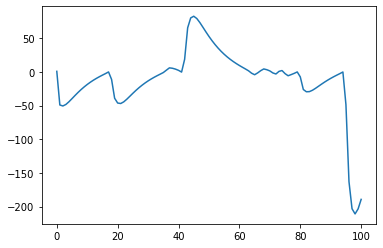

In [24]:
plt.plot(y)

In [25]:
sweeper = np.arange(-1.5,1.5,.1)

In [26]:
def rescale_A(params, s):
    p = params.copy()
    p.A = s*p.A
    
    return p
    

In [27]:
trajectories = [Trajectory(state, dyn, rescale_A(params, s)) for s in sweeper ]

In [28]:
[t.apply_dynamics(25) for t in trajectories]

ys = np.array([[p.y for p in t.points ] for t in trajectories])

In [29]:
ys.shape

(30, 26)

(0.0, 25.0, -1000.0, 1000.0)

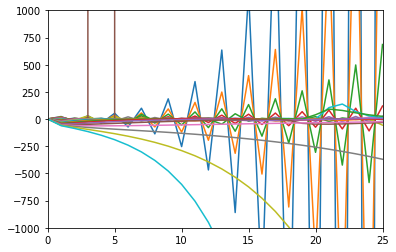

In [30]:
plt.plot(ys.T)
plt.axis([0,25,-1000,1000])
#plt.legend(sweeper)